# Read me

This code will take about 3 hours to run on Google Colab premium. We purchased 100 computing units for this coursework.

This code uses about 16 GB of VRAM because of the data agumentation process.

To run this notebook, you have to upload a file called `data.zip` to the run time which contains the full clocks dataset (image size 150x150).

For the transfer learning, we used the following 2 notebooks as guidance:

-  https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

- https://www.kaggle.com/code/avantikab/time-image-classification-with-vgg16/notebook


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
import keras
from sklearn.model_selection import train_test_split
import zipfile
import os
from tensorflow.keras.utils import to_categorical
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# Load the data

In [ ]:
file_path = '/content/data.zip'
try:
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        extract_path = '/content/data'
        os.makedirs(extract_path, exist_ok=True)
        zip_ref.extractall(extract_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except zipfile.BadZipFile:
    print(f"Error: Invalid zip file at {file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [ ]:
images = np.load('data/images.npy')
labels = np.load('data/labels.npy')

# Test val test split

In [ ]:
#Split into 60% training 40% test + val
X_train_images, X_temp, y_train, y_temp = train_test_split(images, labels,test_size=0.4, random_state=42, shuffle=True)

#Split test+val 50% -> 20% each
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

In [ ]:
#Labels on a string format like "11:01"
y_train_string = []
for i in y_train:
  y_train_string.append(f"{i[0]}:{i[1]}")

In [ ]:
#Same for val and test labels
y_val_string = []
for i in y_val:
  y_val_string.append(f"{i[0]}:{i[1]}")

y_test_string = []
for i in y_test:
  y_test_string.append(f"{i[0]}:{i[1]}")

# Data Augmentation

In [ ]:
#Dictionary to store indices of labels
labels_dict = {}
for idx,label in enumerate(y_train_string):
  if label in labels_dict.keys():
    labels_dict[label] += [idx]
  else:
    labels_dict[label] = [idx]

In [ ]:
#Function to augmentate data by scale_factor, augmented images will be randomly rotated from -360 to 360, with zoom from 90% to 110% and up to 15% shear
def augmentate_data(scale_factor):
  #Images with the channel dimension
  images_plus1 = X_train_images.reshape(X_train_images.shape+(1,))
  img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360,zoom_range=[0.9, 1.1],shear_range=15,data_format="channels_last",dtype=np.uint8)

  all_images = []
  y_train_augmented_string = []

  for i,label in enumerate(labels_dict.keys()):
    images_flow = img_gen.flow(images_plus1[labels_dict[label]], batch_size=25)
    for idx,imgs in enumerate(images_flow):
      all_images.extend(imgs)
      for j in range(len(imgs)):
        y_train_augmented_string.append(label)

      if idx >= (scale_factor -1):
        break
  return  np.array(np.squeeze(all_images)),np.array(y_train_augmented_string)

15x the training data

In [ ]:
X_train_augmented,y_train_augmented_string=augmentate_data(15)

In [ ]:
print(X_train_augmented.shape)
print(X_train_images.shape)

(162000, 150, 150)
(10800, 150, 150)


#Prepare the data

In [ ]:
epochs = 30

In [ ]:
#Turn the augmented labels back
y_train_augmented = []
for i in y_train_augmented_string:
  y_train_augmented.append([int(x) for x in i.split(':')])

y_train_augmented = np.array(y_train_augmented)
y_train_augmented.shape

(162000, 2)

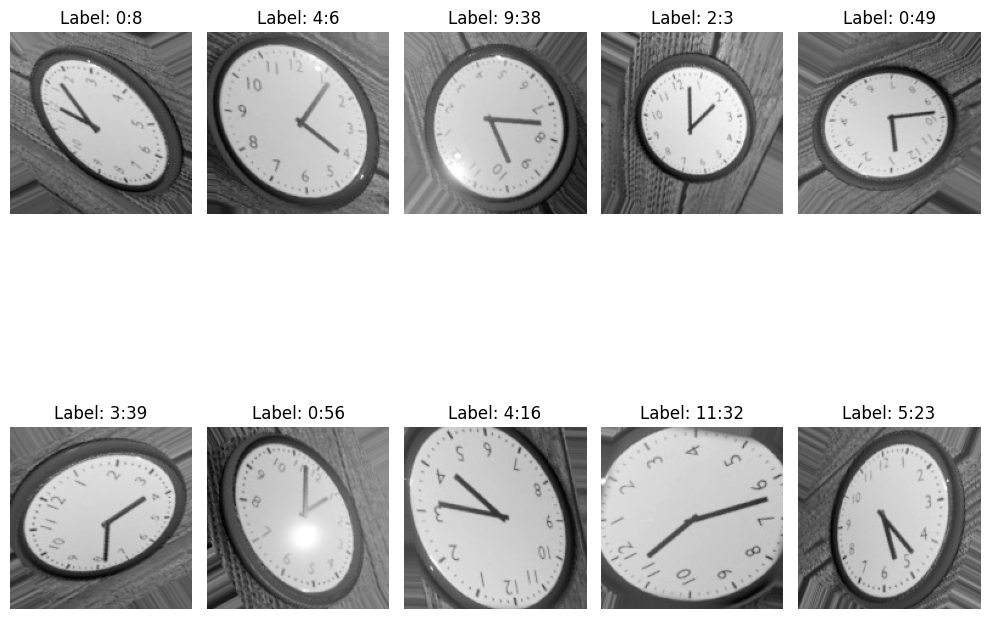

In [ ]:
#Display 10 random images
n_random = X_train_augmented.shape[0]
idx_image = np.random.choice(n_random, size=10, replace=False)

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train_augmented[idx_image[i]], cmap='gray')
    plt.title(f"Label: {y_train_augmented_string[idx_image[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#Later we will need the images as rgb
images_tensor = tf.convert_to_tensor(X_train_augmented, dtype=tf.uint8)
images_tensor = tf.expand_dims(images_tensor, axis=-1)
X_train = tf.image.grayscale_to_rgb(images_tensor)
X_train.shape


TensorShape([162000, 150, 150, 3])

In [ ]:
#Same for test and val images
images_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.uint8)
images_val_tensor = tf.expand_dims(images_val_tensor, axis=-1)
X_val = tf.image.grayscale_to_rgb(images_val_tensor)

images_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.uint8)
images_test_tensor = tf.expand_dims(images_test_tensor, axis=-1)
X_test = tf.image.grayscale_to_rgb(images_test_tensor)
X_test.shape

TensorShape([3600, 150, 150, 3])

#Classification task

## Prepare data for classification

In [ ]:
#For the classification task we need to onehot encode all the labels to do so we create a mapping to convert
#string labels to integers and then we can onehot encode them with the tensorflow function to_categorical

label_train_mapping = {label: i for i, label in enumerate(np.unique(y_train_string))}
labels_train_int = [label_train_mapping[label] for label in y_train_augmented_string]
y_train_one_hot = to_categorical(labels_train_int)



label_test_mapping = {label: i for i, label in enumerate(np.unique(y_train_string))}
labels_test_int = [label_test_mapping[label] for label in y_test_string]
y_test_one_hot = to_categorical(labels_test_int)



label_val_mapping = {label: i for i, label in enumerate(np.unique(y_train_string))}
labels_val_int = [label_val_mapping[label] for label in y_val_string]
y_val_one_hot = to_categorical(labels_val_int)

#We also need the data as tensors
y_train_one_hot = tf.convert_to_tensor(y_train_one_hot)
y_val_one_hot = tf.convert_to_tensor(y_val_one_hot)
y_test_one_hot = tf.convert_to_tensor(y_test_one_hot)


# Display the shapes of the splits
print(f'Train set shape: X: {X_train.shape}, y: {y_train_one_hot.shape}')
print(f'Validation set shape: X: {X_val.shape}, y: {y_val_one_hot.shape}')
print(f'Test set shape: X: {X_test.shape}, y: {y_test_one_hot.shape}')

Train set shape: X: (162000, 150, 150, 3), y: (162000, 720)
Validation set shape: X: (3600, 150, 150, 3), y: (3600, 720)
Test set shape: X: (3600, 150, 150, 3), y: (3600, 720)


In [ ]:
#We can now delete variables we don't need anymore
del images
del labels
del images_tensor

# Run garbage collection to free up memory on the CPU
gc.collect()

# Clear memory on the GPU
tf.keras.backend.clear_session()

## Transfer Learning for Classification

In [ ]:
image_size = X_train.shape[1]
base_model = VGG16(include_top = False,
                       weights = 'imagenet',
                       input_shape = (image_size, image_size, 3)) # Image size

base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#The last 3 layers are the ones we are going to train
for layer in base_model.layers[:-3]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

# Set the final layer to k = 720 = 12*60 classes
outputs = Dense(720, activation='softmax')(x)

model = Model(inputs=base_model.inputs, outputs=outputs)

# Small learning rate to only slightly adjust the weights
# Use categorical cross entropy since we have one hot encoded the response
model.compile(optimizer=Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,6

 Total params: 15,348,752 (58.55 MB)

 Trainable params: 5,352,656 (20.42 MB)

 Non-trainable params: 9,996,096 (38.13 MB)

In [ ]:
#We are going to use 3 callbacks modelcheckpoint to save the best epoch not the last, early stopping to stop training
#if model is not learning for 9 consecutive epochs and reducelronplateau to reduce learning rate if model plateus

model_name = "model_classification.h5.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 9, verbose = 1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [ ]:
try:
  history = model.fit(X_train, y_train_one_hot,
                        epochs=epochs,
                        batch_size=128,
                        validation_data=(X_val, y_val_one_hot),
                        callbacks=[checkpoint,earlystopping,reduce_lr]
                       )
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.0156 - loss: 5.8477
Epoch 1: val_loss improved from inf to 4.27019, saving model to model_classification.h5.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 232s 158ms/step - accuracy: 0.0156 - loss: 5.8470 - val_accuracy: 0.0508 - val_loss: 4.2702 - learning_rate: 0.0010
Epoch 2/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.2075 - loss: 2.8465
Epoch 2: val_loss improved from 4.27019 to 2.47109, saving model to model_classification.h5.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 174s 137ms/step - accuracy: 0.2076 - loss: 2.8463 - val_accuracy: 0.2592 - val_loss: 2.4711 - learning_rate: 0.0010
Epoch 3/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.3880 - loss: 1.8533
Epoch 3: val_loss improved from 2.47109 to 1.58833, saving model to model_classification.h5.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 173s 137ms/step - accuracy: 0.3881 - loss: 1.8532 - val_accuracy: 0.4211 - val_loss: 1.5883 - learning_rate: 0.0010

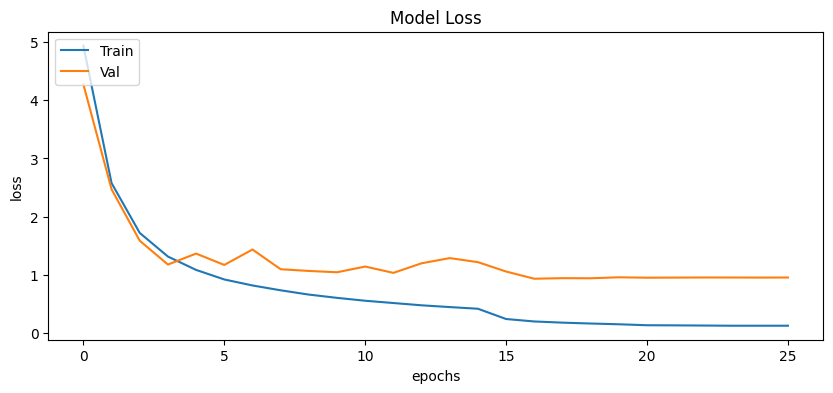

In [ ]:
# Plot loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train','Val'], loc= 'upper left')
plt.show()

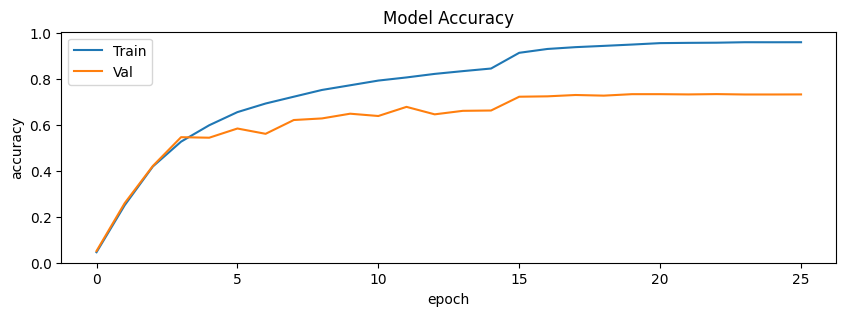

In [ ]:
# Plot accuracy
plt.figure(figsize=(10,3))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Model evaluation

In [ ]:
# Test set accuracy
model.evaluate(X_test, y_test_one_hot)

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.7485 - loss: 0.8573


[0.9125643372535706, 0.7325000166893005]

In [ ]:
#Predictions from 0 to 719
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
y_pred


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step


array([418, 190, 672, ..., 190, 392, 289])

In [ ]:
#True labels also from 0 to 719
y_true = np.argmax(y_test_one_hot,axis=1)
y_true

array([417, 190, 672, ..., 191, 391, 291])

In [ ]:
def common_sense(true,pred):
      diff=abs(true-pred)
      return min(diff,720-diff)

In [ ]:
common_sense_mins = [None] * len(y_true)
for idx in range(len(y_true)):
    diff = common_sense(y_true[idx],y_pred[idx])
    common_sense_mins[idx] = diff

mean_common_sense_mins = np.mean(common_sense_mins)
print(f"Minutes = Mean common sense: {mean_common_sense_mins}")

Minutes = Mean common sense: 2.8780555555555556


#Regression task

##Prepare data for regression

In [ ]:
#For this task we will encode labels as decimals as required so 1:30 = 1.5
#but also as whole minutes so 1:30 =60*1+30 = 90
def encode_time_labels_minutes(labels):
    if labels.shape[1] != 2:
        raise ValueError("Labels should have shape (n_samples, 2) with (hour, minute) pairs.")
    encoded_labels = labels[:, 0] * 60 + labels[:, 1]
    return encoded_labels

def encode_time_labels_decimal(labels):
    if labels.shape[1] != 2:
        raise ValueError("Labels should have shape (n_samples, 2) with (hour, minute) pairs.")

    encoded_labels = labels[:, 0] + labels[:, 1] / 60
    return encoded_labels

def decode_decimal_to_minutes(decimal_labels):
    hours = decimal_labels.astype(int)
    minutes = (decimal_labels - hours) * 60

    total_minutes = hours * 60 + minutes
    return total_minutes



In [ ]:
print(y_val.shape)

(3600, 2)


In [ ]:
#decimal labels
y_train_decimal=encode_time_labels_decimal(y_train_augmented)
y_val_decimal=encode_time_labels_decimal(y_val)
y_test_decimal=encode_time_labels_decimal(y_test)

y_train_decimal = tf.convert_to_tensor(y_train_decimal)
y_val_decimal = tf.convert_to_tensor(y_val_decimal)
y_test_decimal = tf.convert_to_tensor(y_test_decimal)

#minutes labels
y_train_minutes=encode_time_labels_minutes(y_train_augmented)
y_val_minutes=encode_time_labels_minutes(y_val)
y_test_minutes=encode_time_labels_minutes(y_test)

y_train_minutes = tf.convert_to_tensor(y_train_minutes)
y_val_minutes = tf.convert_to_tensor(y_val_minutes)
y_test_minutes = tf.convert_to_tensor(y_test_minutes)



print(f'Train set shape: X: {X_train.shape}, y: {y_train_decimal.shape}')
print(f'Validation set shape: X: {X_val.shape}, y: {y_val_decimal.shape}')
print(f'Test set shape: X: {X_test.shape}, y: {y_test_decimal.shape}')

Train set shape: X: (162000, 150, 150, 3), y: (162000,)
Validation set shape: X: (3600, 150, 150, 3), y: (3600,)
Test set shape: X: (3600, 150, 150, 3), y: (3600,)


##Transfer Learning for Decimal Regression

In [ ]:
#Very similar to the classification but now output has 1 single neuron with range(0-720)
#and the loss function is now mean absolute error
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

outputs = Dense(1, activation='linear')(x)

model = Model(inputs=base_model.inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.001),
             loss='mean_absolute_error',
             metrics=['mean_absolute_error'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,6

 Total params: 14,979,905 (57.14 MB)

 Trainable params: 4,983,809 (19.01 MB)

 Non-trainable params: 9,996,096 (38.13 MB)

In [ ]:
model_name = "model_reg_decimal.h5.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

In [ ]:
try:
  history = model.fit(X_train, y_train_decimal,
                        epochs=epochs,
                        batch_size=128,
                        validation_data=(X_val, y_val_decimal),
                        callbacks=[checkpoint,earlystopping,reduce_lr]
                       )
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 2.6917 - mean_absolute_error: 2.6917
Epoch 1: val_loss improved from inf to 1.00759, saving model to model_reg_decimal.h5.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 182s 140ms/step - loss: 2.6910 - mean_absolute_error: 2.6910 - val_loss: 1.0076 - val_mean_absolute_error: 1.0076 - learning_rate: 0.0010
Epoch 2/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 1.1217 - mean_absolute_error: 1.1217
Epoch 2: val_loss improved from 1.00759 to 0.74277, saving model to model_reg_decimal.h5.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 173s 137ms/step - loss: 1.1217 - mean_absolute_error: 1.1217 - val_loss: 0.7428 - val_mean_absolute_error: 0.7428 - learning_rate: 0.0010
Epoch 3/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.8392 - mean_absolute_error: 0.8392
Epoch 3: val_loss improved from 0.74277 to 0.73105, saving model to model_reg_decimal.h5.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 173s 137ms/step - loss: 0.8392 - mean_absolute_

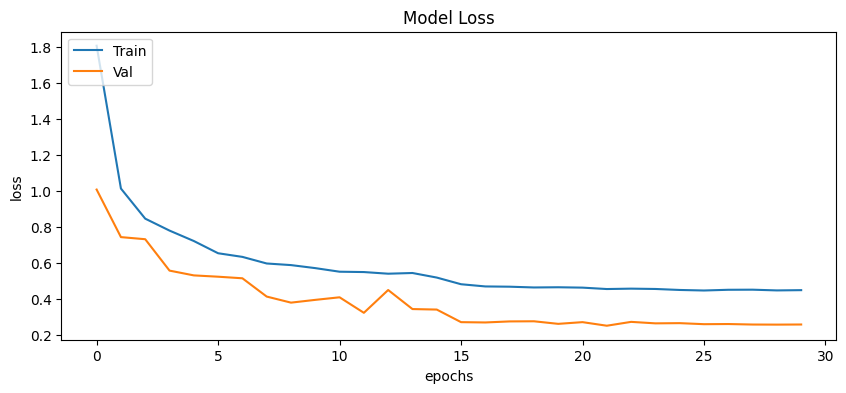

In [ ]:
# Plot loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train','Val'], loc= 'upper left')
plt.show()

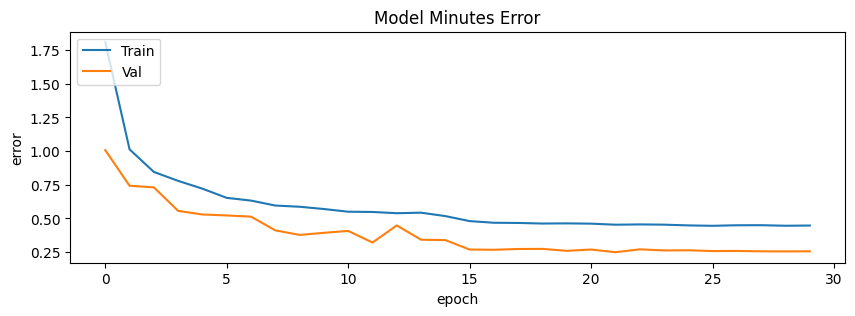

In [ ]:
# Plot error
plt.figure(figsize=(10,3))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Minutes Error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Model evaluation


In [ ]:
model.evaluate(X_test, y_test_decimal)

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2421 - mean_absolute_error: 0.2421


[0.24356186389923096, 0.24356186389923096]

In [ ]:
y_pred=decode_decimal_to_minutes(model.predict(X_test))
y_true=decode_decimal_to_minutes(y_test_decimal.numpy())

common_sense_mins = [None] * len(y_true)
for idx in range(len(y_true)):
    diff = common_sense(y_true[idx],y_pred[idx])
    common_sense_mins[idx] = diff

mean_common_sense_mins = np.mean(common_sense_mins)
print(f"Minutes = Mean common sense: {mean_common_sense_mins}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step
Minutes = Mean common sense: 14.516772238678403


##Transfer Learning for Minutes Regression

In [ ]:
model_name = "model_reg_minutes.h5.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

In [ ]:
#Same model just different labels
try:
  history = model.fit(X_train, y_train_minutes,
                        epochs=epochs,
                        batch_size=128,
                        validation_data=(X_val, y_val_minutes),
                        callbacks=[checkpoint,earlystopping,reduce_lr]
                       )
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 353.2423 - mean_absolute_error: 353.2423
Epoch 1: val_loss improved from inf to 354.13391, saving model to model_reg_minutes.h5.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 181s 140ms/step - loss: 353.2419 - mean_absolute_error: 353.2419 - val_loss: 354.1339 - val_mean_absolute_error: 354.1339 - learning_rate: 1.0000e-06
Epoch 2/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 352.4839 - mean_absolute_error: 352.4839
Epoch 2: val_loss improved from 354.13391 to 353.94037, saving model to model_reg_minutes.h5.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 173s 137ms/step - loss: 352.4839 - mean_absolute_error: 352.4839 - val_loss: 353.9404 - val_mean_absolute_error: 353.9404 - learning_rate: 1.0000e-06
Epoch 3/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 352.1277 - mean_absolute_error: 352.1277
Epoch 3: val_loss improved from 353.94037 to 353.75024, saving model to model_reg_minutes.h5.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1

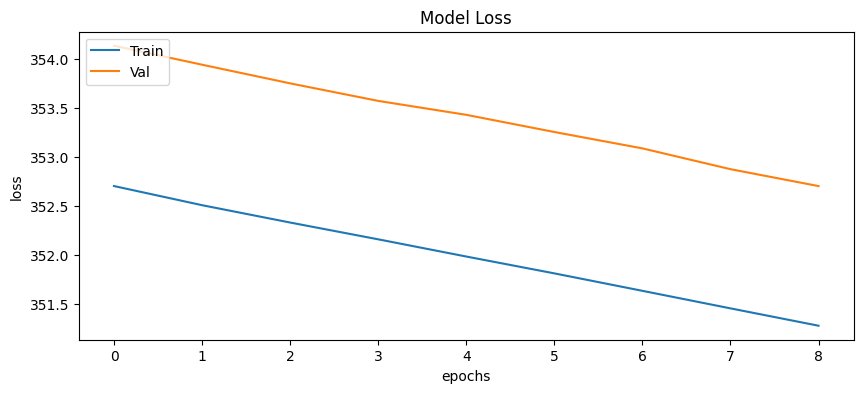

In [ ]:
# Plot loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train','Val'], loc= 'upper left')
plt.show()

The plot is just a straight line because the learning rate is 10e-6. This was a mistake from our side since we did not reset the learning rate back to 0.001. However, when we realised this mistake it was too late and we did not want to restart the code as it takes about 3 hours to run this file...

We did run this experiment in a seperate file and we observed similar common sense difference as in the decimal encoding regression case.

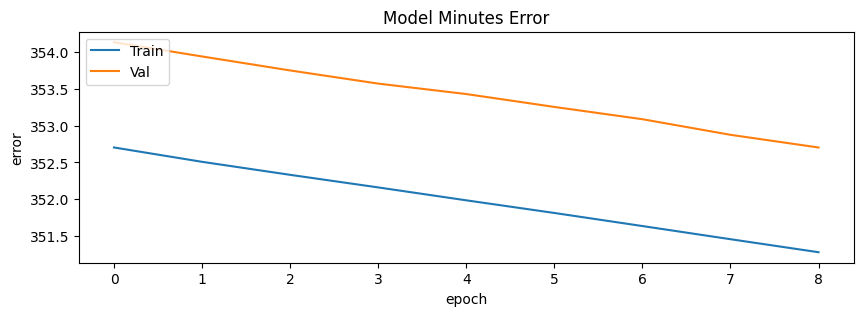

In [ ]:
# Plot error
plt.figure(figsize=(10,3))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Minutes Error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Model evaluation


In [ ]:
model.evaluate(X_test, y_test_minutes)

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 355.6670 - mean_absolute_error: 355.6670


[354.64312744140625, 354.64312744140625]

In [ ]:
y_pred=model.predict(X_test)
y_true=y_test_minutes

common_sense_mins = [None] * len(y_true)
for idx in range(len(y_true)):
    diff = common_sense(y_true[idx],y_pred[idx])
    common_sense_mins[idx] = diff

mean_common_sense_mins = np.mean(common_sense_mins)
print(f"Minutes = Mean common sense: {mean_common_sense_mins}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
Minutes = Mean common sense: 185.26416666666665


This common sense differnce is not representative since we messed up the learning rate. In a seperate experiment (not submitted) we showed that the common sense difference was similar to the decimal regression case.

#Multi-head Classification-Regression

##Prepare data for classification and regression

In [ ]:
#We need to separete labels into labels_hours and labels_minutes for each dataset
y_train_hours_augmented = [x[0] for x in y_train_augmented]
y_train_minutes_augmented = [x[1] for x in y_train_augmented]

y_val_hours = [x[0] for x in y_val]
y_val_minutes = [x[1] for x in y_val]

y_test_hours = [x[0] for x in y_test]
y_test_minutes = [x[1] for x in y_test]

In [ ]:
#As we are doing classification for hours we need to onehot encode all the hours labels

y_train_hours_one_hot = to_categorical(y_train_hours_augmented)
y_test_hours_one_hot = to_categorical(y_test_hours)
y_val_hours_one_hot = to_categorical(y_val_hours)



# Convert to tensors
y_train_hours_one_hot = tf.convert_to_tensor(y_train_hours_one_hot)
y_train_minutes = tf.convert_to_tensor(y_train_minutes_augmented)

y_val_hours_one_hot = tf.convert_to_tensor(y_val_hours_one_hot)
y_val_minutes = tf.convert_to_tensor(y_val_minutes)

y_test_hours_one_hot = tf.convert_to_tensor(y_test_hours_one_hot)
y_test_minutes = tf.convert_to_tensor(y_test_minutes)

print(f'Train set hours shape: X: {X_train.shape}, y: {y_train_hours_one_hot.shape}')
print(f'Validation set hours shape: X: {X_val.shape}, y: {y_val_hours_one_hot.shape}')
print(f'Test set hours shape: X: {X_test.shape}, y: {y_test_hours_one_hot.shape}')

print(f'Train set minutes shape: X: {X_train.shape}, y: {y_train_minutes.shape}')
print(f'Validation set minutes shape: X: {X_val.shape}, y: {y_val_minutes.shape}')
print(f'Test set minutes shape: X: {X_test.shape}, y: {y_test_minutes.shape}')


Train set hours shape: X: (162000, 150, 150, 3), y: (162000, 12)
Validation set hours shape: X: (3600, 150, 150, 3), y: (3600, 12)
Test set hours shape: X: (3600, 150, 150, 3), y: (3600, 12)
Train set minutes shape: X: (162000, 150, 150, 3), y: (162000,)
Validation set minutes shape: X: (3600, 150, 150, 3), y: (3600,)
Test set minutes shape: X: (3600, 150, 150, 3), y: (3600,)


##Transfer Learning for Multi-head Classification Regression

In [ ]:
model_name = "model_multihead.h5.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

In [ ]:
last_output = base_model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)

# Set the final layer to 12 classes (hours) and 1 for regression on the minutes
hour_output = keras.layers.Dense(12, activation='softmax',name='hour_output')(x)
minute_output = keras.layers.Dense(1, activation='linear',name='minute_output')(x)

model = Model(inputs=base_model.inputs, outputs=[hour_output,minute_output])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'hour_output':'categorical_crossentropy','minute_output':'mae'},
              metrics={'hour_output':['accuracy'],'minute_output':['mae']})

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 150, 150, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 150, 150, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 75, 75, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 75, 75, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 75, 75, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 37, 37, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 37, 37, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 37, 37, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 37, 37, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 18, 18, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 18, 18, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 18, 18, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 18, 18, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 9, 9, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 9, 9, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 9, 9, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 14,986,061 (57.17 MB)

 Trainable params: 4,989,965 (19.04 MB)

 Non-trainable params: 9,996,096 (38.13 MB)

In [ ]:
try:
  history = model.fit(X_train, {'hour_output': y_train_hours_one_hot, 'minute_output': y_train_minutes},
                        epochs=epochs,
                        batch_size=128,
                        validation_data=(X_val, {'hour_output': y_val_hours_one_hot, 'minute_output': y_val_minutes}),
                        callbacks=[checkpoint,earlystopping,reduce_lr]
                       )
except KeyboardInterrupt:
    print("\nTraining Stopped")

Epoch 1/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - hour_output_accuracy: 0.6525 - loss: 14.6780 - minute_output_mae: 13.7544
Epoch 1: val_loss improved from inf to 3.44752, saving model to model_multihead.h5.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 186s 142ms/step - hour_output_accuracy: 0.6526 - loss: 14.6730 - minute_output_mae: 13.7496 - val_hour_output_accuracy: 0.9169 - val_loss: 3.4475 - val_minute_output_mae: 3.1584 - learning_rate: 0.0010
Epoch 2/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - hour_output_accuracy: 0.8607 - loss: 4.3615 - minute_output_mae: 3.9791
Epoch 2: val_loss improved from 3.44752 to 3.12120, saving model to model_multihead.h5.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 174s 138ms/step - hour_output_accuracy: 0.8607 - loss: 4.3615 - minute_output_mae: 3.9791 - val_hour_output_accuracy: 0.9333 - val_loss: 3.1212 - val_minute_output_mae: 2.8870 - learning_rate: 0.0010
Epoch 3/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - hour_output_accuracy: 0.8941 - los

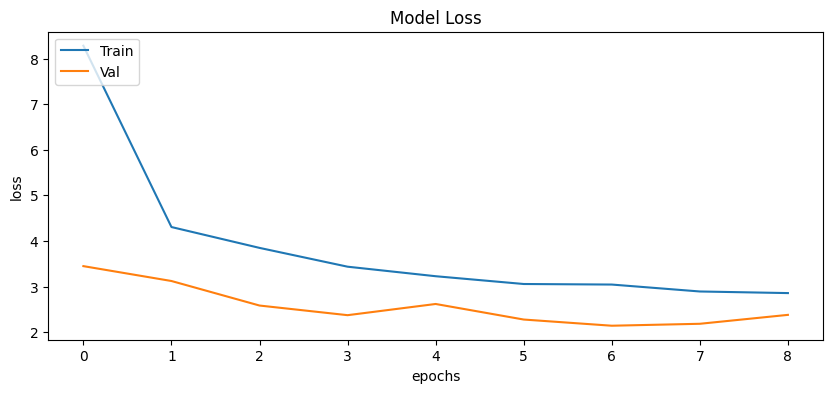

In [ ]:
# Plot loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train','Val'], loc= 'upper left')
plt.show()

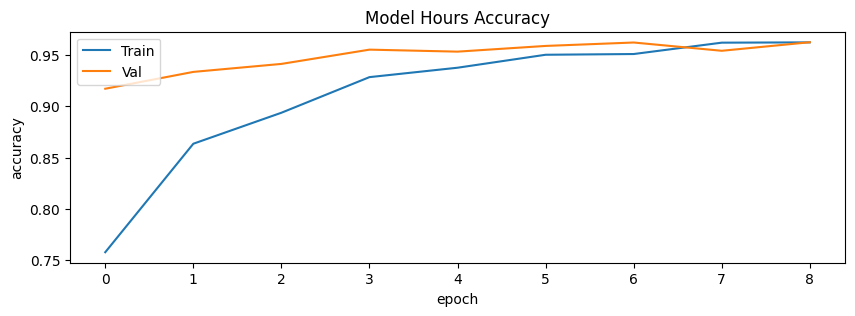

In [ ]:
# Plot hours accuracy
plt.figure(figsize=(10,3))
plt.plot(history.history['hour_output_accuracy'])
plt.plot(history.history['val_hour_output_accuracy'])
plt.title('Model Hours Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

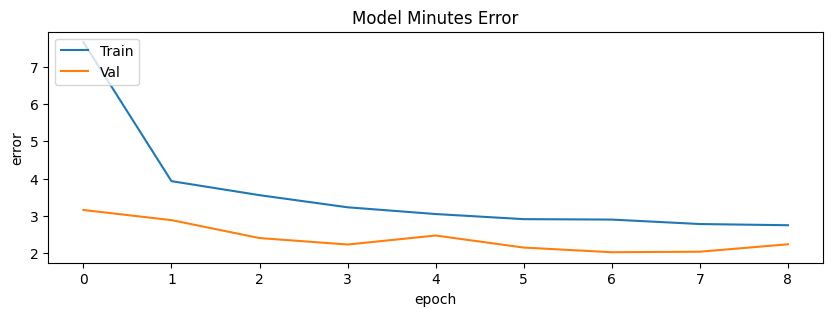

In [ ]:
# Plot minutes error
plt.figure(figsize=(10,3))
plt.plot(history.history['minute_output_mae'])
plt.plot(history.history['val_minute_output_mae'])
plt.title('Model Minutes Error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Model evaluation


In [ ]:
model.evaluate(X_test, {'hour_output': y_test_hours_one_hot, 'minute_output': y_test_minutes})

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - hour_output_accuracy: 0.9160 - loss: 3.4145 - minute_output_mae: 3.1321


[3.3599536418914795, 0.914722204208374, 3.0781664848327637]

In [ ]:
y_pred = model.predict(X_test)
predicted_hours = np.argmax(y_pred[0], axis=1)
predicted_minutes = np.squeeze(y_pred[1])
y_pred = predicted_hours*60+predicted_minutes


y_true = np.array(y_test_hours)*60+np.array(y_test_minutes)

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step


In [ ]:
common_sense_mins = [None] * len(y_true)
for idx in range(len(y_true)):
    diff = common_sense(y_true[idx],y_pred[idx])
    common_sense_mins[idx] = diff

mean_common_sense_mins = np.mean(common_sense_mins)
print(f"Minutes = Mean common sense: {mean_common_sense_mins}")

Minutes = Mean common sense: 7.401276532022489
